### Loading Data 

In [1]:
import numpy as np
import os
import time, calendar, datetime
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 15)
import glob
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
os.chdir('/home/gaurav/Desktop/Research Paper/Geolife Trajectories 1.3/Data')
## Getting list of all users (182 users)
list_of_folder = glob.glob('*')   
list_of_folder.sort()

#### For user 000 only

In [3]:
%%time
folder_name='/home/gaurav/Desktop/Research Paper/Geolife Trajectories 1.3/Data/'+'000'+'/Trajectory'
# Change directory
os.chdir(folder_name) 
data=[]
# List of all files for a particular user 
list_of_files = glob.glob('*.plt')
for file_name in list_of_files:
    
    data.append((np.genfromtxt(file_name,delimiter=',',skip_header=6,names=['Latitude','Longitude','Zero','Altitude',
                                                                                 'Duration','Date','Time'],
                          dtype=[('Latitude','f8'),('Longitude','f8'),('Zero','i8'),('Altitude','f8'),('Duration','f8'),
                                ('Date','S10'),('Time','S8')])))


CPU times: user 1.67 s, sys: 24 ms, total: 1.7 s
Wall time: 2.47 s


In [4]:
data[0]

array([ (39.99984, 116.325001, 0, 487.0, 39999.1202199074, b'2009-07-05', b'02:53:07'),
       (39.999899, 116.324809, 0, 477.0, 39999.1202777778, b'2009-07-05', b'02:53:12'),
       (40.000017, 116.324672, 0, 468.0, 39999.1203356481, b'2009-07-05', b'02:53:17'),
       ...,
       (40.000443, 116.327186, 0, 150.0, 39999.322974537, b'2009-07-05', b'07:45:05'),
       (40.000522, 116.327132, 0, 149.0, 39999.3230324074, b'2009-07-05', b'07:45:10'),
       (40.000543, 116.327148, 0, 150.0, 39999.3230902778, b'2009-07-05', b'07:45:15')], 
      dtype=[('Latitude', '<f8'), ('Longitude', '<f8'), ('Zero', '<i8'), ('Altitude', '<f8'), ('Duration', '<f8'), ('Date', 'S10'), ('Time', 'S8')])

In [5]:
Num_of_row=0
for i in range(len(data)):
    Num_of_row +=len(data[i])
print(Num_of_row)

173870


## Clustering 

In [6]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle

In [7]:
# define the number of kilometers in one radian
kms_per_radian = 6371.0088
os.chdir('/home/gaurav/Desktop/Research Paper/prop_labs/')

In [8]:
fields = ['lat','long','subfolder','datetime']

In [9]:
df = pd.read_csv('all.csv',encoding='utf-8',nrows=Num_of_row,usecols=fields)
df['Day']=df.datetime.apply(lambda x : x[0:10])

In [10]:
df['Day']=df.Day.apply(lambda x : datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%A'))
df.head()

,lat,long,subfolder,datetime,Day
0,39.984702,116.318417,0,2008-10-23 02:53:04,Thursday
1,39.984683,116.318450,0,2008-10-23 02:53:10,Thursday
2,39.984686,116.318417,0,2008-10-23 02:53:15,Thursday
3,39.984688,116.318385,0,2008-10-23 02:53:20,Thursday
4,39.984655,116.318263,0,2008-10-23 02:53:25,Thursday


In [11]:
sumi=0
df['day_no']=0
for j in range(len(data)):
    df.day_no[sumi:sumi+len(data[j])]=j
    sumi=sumi+len(data[j])

In [12]:
# define epsilon as 1.5 kilometers, converted to radians for use by haversine
epsilon = 1.5/ kms_per_radian

In [13]:
datamin=df.iloc[::4,:]

In [14]:
coords = datamin.as_matrix(columns=['lat', 'long'])

In [15]:
start_time = time.time()
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_

# get the number of clusters
n_clusters_ = len(set(cluster_labels))
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 5


In [16]:
# turn the clusters in to a pandas series, where each element is a cluster of points
clusters = pd.Series([coords[cluster_labels==n] for n in range(n_clusters_)])

In [17]:
clusters[0]

array([[  39.984702,  116.318417],
       [  39.984655,  116.318263],
       [  39.984539,  116.317294],
       ..., 
       [  40.000016,  116.327371],
       [  40.00032 ,  116.327315],
       [  40.000522,  116.327132]])

## Visualization on Map

In [18]:
import smopy 
%matplotlib inline

In [19]:
lat_min=min(df.lat)
lon_min=min(df.long)
lat_max=max(df.lat)
lon_max=max(df.long)

Lowered zoom level to keep map size reasonable. (z = 7)


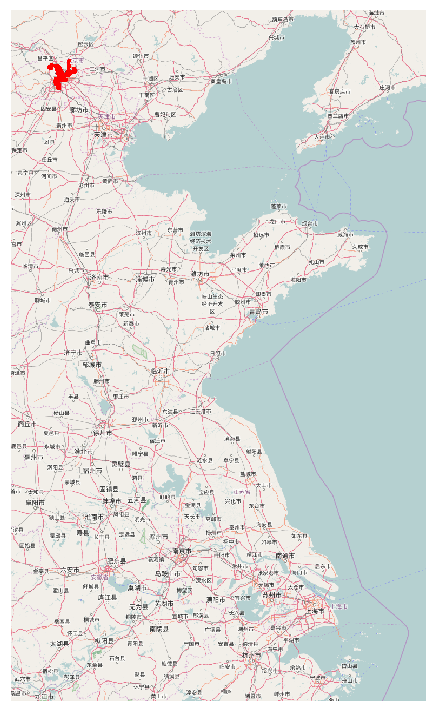

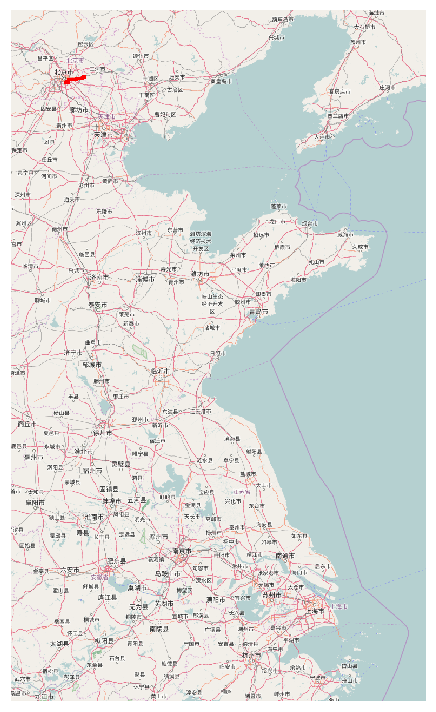

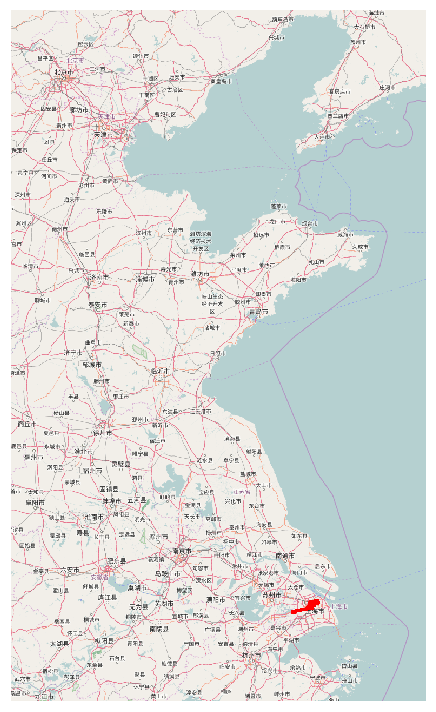

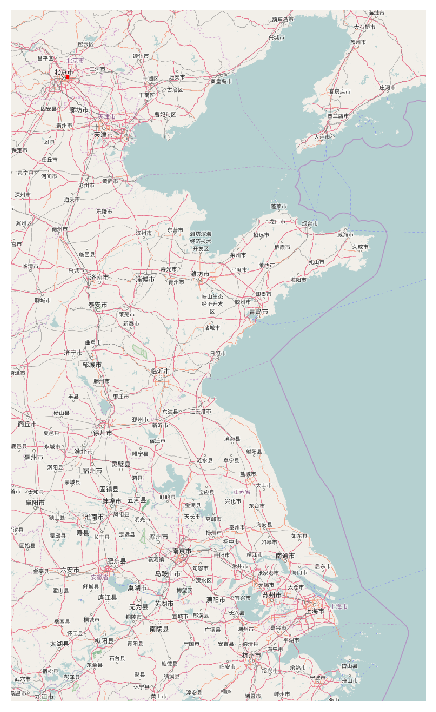

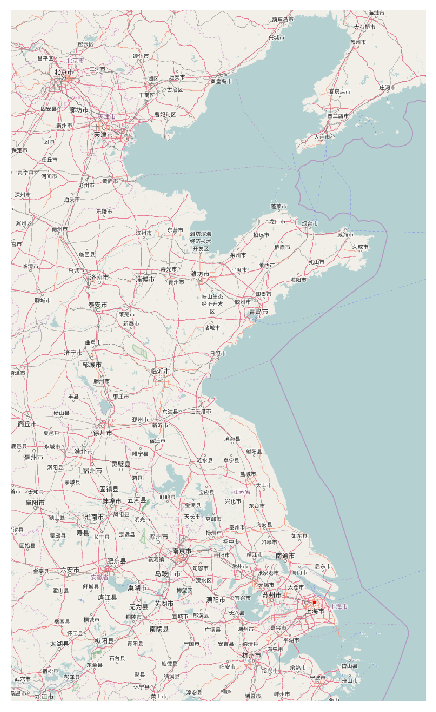

In [20]:
map = smopy.Map((lat_min,lon_min,lat_max,lon_max), z=10)
for i in range(n_clusters_):
    x, y = map.to_pixels(clusters[i][:,0], clusters[i][:,1])
    ax = map.show_mpl(figsize=(10, 10))
    ax.plot(x, y, 'or', ms=2,color='r')
#map.show_ipython()

In [21]:
len((cluster_labels))

43468

In [22]:
clusters

0    [[39.984702, 116.318417], [39.984655, 116.3182...
1    [[39.906754, 116.472397], [39.906736, 116.4728...
2    [[31.168503, 121.399589], [31.16857, 121.39954...
3    [[39.948712, 116.457223], [39.948783, 116.4575...
4    [[31.272391, 121.4758], [31.272491, 121.475365...
dtype: object

### Adding the cluster labels to each row

In [23]:
datamin['cluster_labels']=cluster_labels

In [24]:
b=[]
for i in range (n_clusters_):
    b.append(len(cluster_labels[cluster_labels==i]))
print(b)

[36857, 2488, 4042, 67, 14]


In [25]:
len(datamin)

43468

In [26]:
datamin.head()

,lat,long,subfolder,datetime,Day,day_no,cluster_labels
0,39.984702,116.318417,0,2008-10-23 02:53:04,Thursday,0,0
4,39.984655,116.318263,0,2008-10-23 02:53:25,Thursday,0,0
8,39.984539,116.317294,0,2008-10-23 02:53:45,Thursday,0,0
12,39.984561,116.316527,0,2008-10-23 02:54:05,Thursday,0,0
16,39.984523,116.315823,0,2008-10-23 02:54:25,Thursday,0,0


In [27]:
datamin.reset_index(drop=True,inplace=True)

In [28]:
datamin.head()

,lat,long,subfolder,datetime,Day,day_no,cluster_labels
0,39.984702,116.318417,0,2008-10-23 02:53:04,Thursday,0,0
1,39.984655,116.318263,0,2008-10-23 02:53:25,Thursday,0,0
2,39.984539,116.317294,0,2008-10-23 02:53:45,Thursday,0,0
3,39.984561,116.316527,0,2008-10-23 02:54:05,Thursday,0,0
4,39.984523,116.315823,0,2008-10-23 02:54:25,Thursday,0,0


In [29]:
a=[]
a.append(datamin.cluster_labels[0])
for i in range (1,2312):
    if(datamin.cluster_labels[i]!=datamin.cluster_labels[i-1]):
        a.append(datamin.cluster_labels[i])

In [30]:
a

[0]

### Sequence of cluster for each date 

In [31]:
Num_of_rows=0
i=0
while(i<7 and Num_of_rows<10000):
    Num_of_rows +=len(data[i])
    i+=1
    
print(i,Num_of_rows)

7 9741


In [32]:
datamin.day_no.unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170])

In [33]:
seq=np.array(datamin.day_no)

In [34]:
count=np.bincount(seq)

In [35]:
count

array([ 578,    3,    7,  496,   50,  400,  902,   84,  312,  218,  590,
         46,  285,  519,  369,  170,  134,  245,  297,    2,  484,   27,
        161,  558,  113,  174,   12,  186,  640,  343,  462,   33,   49,
        149,  167,  830,  466,  253,  229,  153,   84,   34,   33,    4,
         29,  180,   70,   89,  369,   20,   20,  780, 1462,  161,   79,
         25,   37,  918,   38,  135,  146,  170,   36,   68,  201,  453,
        627,  109,  302, 1001,   73,   30,  918,   38,   11,   22,   70,
         21,  227,   21,  711,  156,  409,   13,  472,  275,   80,   46,
        124,   24,   21,  171,  559,   43,   20,   24,  362,  204,  520,
          5,  451,    2,   12,    6, 1196,  317,   71,   24,  347,  115,
        271,   76,   24,  929,  194,  177,  332,   22,   46,  143, 3546,
          5,   37,   77,   61,   24,   21,  447,  501,   70,  444,  135,
         27,  560,  367,  255,  455,  337,   42,  268,  162,  106,  270,
        580,   30,   55,   93, 1440,    1,  740,   

In [36]:
sequence=[]
Num_of_rows=0
for i in range (len(count)):
    
    a=[]
    a.append(datamin.cluster_labels[Num_of_rows])
    for j in range (Num_of_rows+1,Num_of_rows+count[i]):
        
        if(datamin.cluster_labels[j]!=datamin.cluster_labels[j-1]):
            
            a.append(datamin.cluster_labels[j])
    sequence.append(a)
    
    Num_of_rows+=count[i]       

In [37]:
sequence

[[0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0, 1],
 [1],
 [1],
 [1, 0],
 [0, 1, 0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0, 1],
 [1],
 [1],
 [1],
 [1],
 [1, 0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0, 2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2, 0],
 [0],
 [0],
 [0],
 [0, 1],
 [1],
 [1],
 [1],
 [1],
 [1, 0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0, 3, 0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0, 2],
 [2],
 [2],
 [2],
 [2, 4, 2],
 [2],
 [2, 0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0]

In [38]:
new_seq=[]
for i in range(len(sequence)):
    if(len(sequence[i])>1):
        new_seq.append(sequence[i])
new_seq

[[0, 1],
 [1, 0],
 [0, 1, 0],
 [0, 1],
 [1, 0],
 [0, 2],
 [2, 0],
 [0, 1],
 [1, 0],
 [0, 3, 0],
 [0, 2],
 [2, 4, 2],
 [2, 0]]

## Hidden Markov Model

### Transition Probablity

In [39]:
transition =np.zeros(shape=(n_clusters_,n_clusters_))
for seq in new_seq:
    for i in range(len(seq)-1):
        transition[seq[i]][seq[i+1]]=transition[seq[i]][seq[i+1]]+1

In [40]:
transition=np.array(transition)

In [41]:
transition

array([[ 0.,  4.,  2.,  1.,  0.],
       [ 4.,  0.,  0.,  0.,  0.],
       [ 2.,  0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.]])

In [42]:
for i in range(n_clusters_):
    sumi=sum(transition[i][0:n_clusters_])
    for j in range(n_clusters_):
        transition[i][j]=(transition[i][j]*1.0)/sumi

In [43]:
transition

array([[ 0.        ,  0.57142857,  0.28571429,  0.14285714,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.66666667,  0.        ,  0.        ,  0.        ,  0.33333333],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ]])

### Initial Probability

In [44]:
intial=[0]*n_clusters_
for seq in new_seq:
    first=seq[0]
    intial[first]+=1

In [45]:
intial/sum(intial)

array([ 0.53846154,  0.23076923,  0.23076923,  0.        ,  0.        ])

### Emission Probability

In [46]:
days=['Sunday','Monday','Tuesday','Wednesday','Thrusday','Friday','Saturday']

In [47]:
emission=np.zeros(shape=(n_clusters_,len(days)))

In [48]:
for j in range(n_clusters_):
    datalen=datamin.loc[datamin.cluster_labels==j,:]
    for i,day in enumerate(days):
        emission[j][i]=len(datalen.loc[datalen.Day==day,:])

In [49]:
emission

array([[ 5144.,  4628.,  5829.,  3209.,     0.,  6090.,  5975.],
       [  978.,     0.,   208.,   559.,     0.,     0.,   310.],
       [ 1448.,   272.,     0.,     0.,     0.,   793.,  1303.],
       [    0.,     0.,     0.,     0.,     0.,     0.,     0.],
       [   14.,     0.,     0.,     0.,     0.,     0.,     0.]])

In [50]:
df.head()

,lat,long,subfolder,datetime,Day,day_no
0,39.984702,116.318417,0,2008-10-23 02:53:04,Thursday,0
1,39.984683,116.318450,0,2008-10-23 02:53:10,Thursday,0
2,39.984686,116.318417,0,2008-10-23 02:53:15,Thursday,0
3,39.984688,116.318385,0,2008-10-23 02:53:20,Thursday,0
4,39.984655,116.318263,0,2008-10-23 02:53:25,Thursday,0


Let us use 5 hidden state.
**Observed state** = Cluster i.e Cluster no. 0,1,2,3,4

We will use Backward Forward algorithm to compute the value of model parameter ,i.e
**Transition Probability ,Emission Probability ,Initial Probability**

In [55]:
def fwd_bkw(observations, states, start_prob, trans_prob, emm_prob, end_st):
    # forward part of the algorithm
    fwd = []
    f_prev = {}
    for i, observation_i in enumerate(observations):
        f_curr = {}
        for st in states:
            if i == 0:
                # base case for the forward part
                prev_f_sum = start_prob[st]
            else:
                prev_f_sum = sum(f_prev[k]*trans_prob[k][st] for k in states)

            f_curr[st] = emm_prob[st][observation_i] * prev_f_sum

        fwd.append(f_curr)
        f_prev = f_curr

    p_fwd = sum(f_curr[k] * trans_prob[k][end_st] for k in states)

    # backward part of the algorithm
    bkw = []
    b_prev = {}
    for i, observation_i_plus in enumerate(reversed(observations[1:]+(None,))):
        b_curr = {}
        for st in states:
            if i == 0:
                # base case for backward part
                b_curr[st] = trans_prob[st][end_st]
            else:
                b_curr[st] = sum(trans_prob[st][l] * emm_prob[l][observation_i_plus] * b_prev[l] for l in states)

        bkw.insert(0,b_curr)
        b_prev = b_curr
    p_bkw = sum(start_prob[l] * emm_prob[l][observations[0]] * b_curr[l] for l in states)
    # merging the two parts
    posterior = []
    for i in range(len(observations)):
        posterior.append({st: fwd[i][st] * bkw[i][st] / p_fwd for st in states})
    assert p_fwd == p_bkw
    return fwd, bkw, posterior

In [58]:
def viterbi(obs, states, start_p, trans_p, emit_p):

    V = [{}]

    for st in states:

        V[0][st] = {"prob": start_p[st] * emit_p[st][obs[0]], "prev": None}

    # Run Viterbi when t > 0

    for t in range(1, len(obs)):

        V.append({})

        for st in states:

            max_tr_prob = max(V[t-1][prev_st]["prob"]*trans_p[prev_st][st] for prev_st in states)

            for prev_st in states:

                if V[t-1][prev_st]["prob"] * trans_p[prev_st][st] == max_tr_prob:

                    max_prob = max_tr_prob * emit_p[st][obs[t]]

                    V[t][st] = {"prob": max_prob, "prev": prev_st}

                    break

    for line in dptable(V):

        print (line)

    opt = []

    # The highest probability

    max_prob = max(value["prob"] for value in V[-1].values())

    previous = None

    # Get most probable state and its backtrack

    for st, data in V[-1].items():

        if data["prob"] == max_prob:

            opt.append(st)

            previous = st

            break

    # Follow the backtrack till the first observation

    for t in range(len(V) - 2, -1, -1):

        opt.insert(0, V[t + 1][previous]["prev"])

        previous = V[t + 1][previous]["prev"]


    print ('The steps of states are ' + ' '.join(opt) + ' with highest probability of %s' % max_prob)


In [63]:
df.head(150000)

,lat,long,subfolder,datetime,Day,day_no
0,39.984702,116.318417,0,2008-10-23 02:53:04,Thursday,0
1,39.984683,116.318450,0,2008-10-23 02:53:10,Thursday,0
2,39.984686,116.318417,0,2008-10-23 02:53:15,Thursday,0
3,39.984688,116.318385,0,2008-10-23 02:53:20,Thursday,0
4,39.984655,116.318263,0,2008-10-23 02:53:25,Thursday,0
5,39.984611,116.318026,0,2008-10-23 02:53:30,Thursday,0
6,39.984608,116.317761,0,2008-10-23 02:53:35,Thursday,0
7,39.984563,116.317517,0,2008-10-23 02:53:40,Thursday,0
8,39.984539,116.317294,0,2008-10-23 02:53:45,Thursday,0
9,39.984606,116.317065,0,2008-10-23 02:53:50,Thursday,0
